In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
train = pd.read_csv('training_images_size.csv', sep='\t')
test = pd.read_csv('testing_images_size.csv', sep='\t')

def read_img(df):
    array = []
    for path in df.imagepath.values:
        img = cv2.imread(path, cv2.COLOR_RGB2GRAY)
        resize = cv2.resize(img, (256, 256), cv2.INTER_LINEAR)
        array.append(resize)
    if 'type' in df.columns:
        img_df = {'type': df.type.values, 'img_array': array}
    else:
        img_df = np.array(array)
    return img_df

### Explainatory Data Analaysis Based on Image Sizes:

In [86]:
train.describe()

,heights,widths,channels
count,1481.000000,1481.000000,1481.0
mean,3661.709656,2783.655638,3.0
std,501.958655,384.097922,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,3264.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


In [87]:
test.describe()

,heights,widths,channels
count,503.000000,503.000000,503.0
mean,3679.968191,2806.556660,3.0
std,536.263239,419.989063,0.0
min,640.000000,480.000000,3.0
25%,3264.000000,2448.000000,3.0
50%,4128.000000,3096.000000,3.0
75%,4128.000000,3096.000000,3.0
max,4160.000000,4128.000000,3.0


Based on the original analysis according to the image sizes, all testing and training images have really high resolution and need to be resized before any other analysis to reduce computational time. The average image size for a training image is (3662,2784,3) while the average for the testing set is (3680, 2806, 3). 

In [3]:
import time

start_time = time.time()
training_imgs = read_img(train)

print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Training data load time: 279.07 seconds


In [4]:
training_df = pd.DataFrame(training_imgs)

In [5]:
from glob import glob

test_paths = glob('test/*')

test['imagepath'] = test_paths

start_time = time.time()
testing_imgs = read_img(test)
print('Testing data load time: {} seconds'.format(round(time.time() - start_time, 2)))

Testing data load time: 95.18 seconds


In [13]:
training_df.to_csv('training_df.csv')

### Explainatory Data Analysis for Training Dataset

In [17]:
training_df.head()

,type,img_array
0,Type_1,"[[[0, 0, 0], [0, 0, 0], [1, 1, 1], [1, 1, 1], ..."
1,Type_1,"[[[31, 85, 105], [47, 96, 118], [57, 99, 119],..."
2,Type_1,"[[[252, 235, 207], [252, 231, 204], [253, 232,..."
3,Type_1,"[[[162, 148, 190], [145, 136, 179], [153, 143,..."
4,Type_1,"[[[71, 32, 24], [78, 39, 25], [93, 53, 35], [1..."


#### Average Image for Each Cervix Type

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


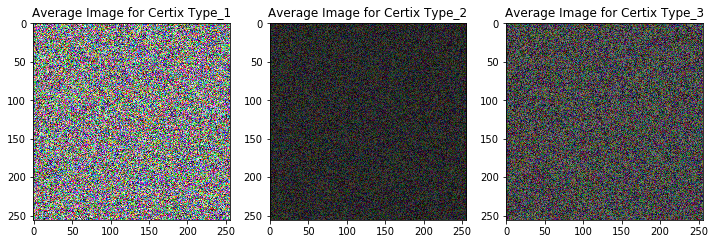

In [67]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(training_df.type.unique()):
    ax = fig.add_subplot(1,3,i+1)
    mean = training_df[training_df.type==t].img_array.mean(axis=0)
    plt.imshow(mean)
    plt.title('Average Image for Certix {}'.format(t))  

#### Find Min and Max Image Based on Norm Vectors

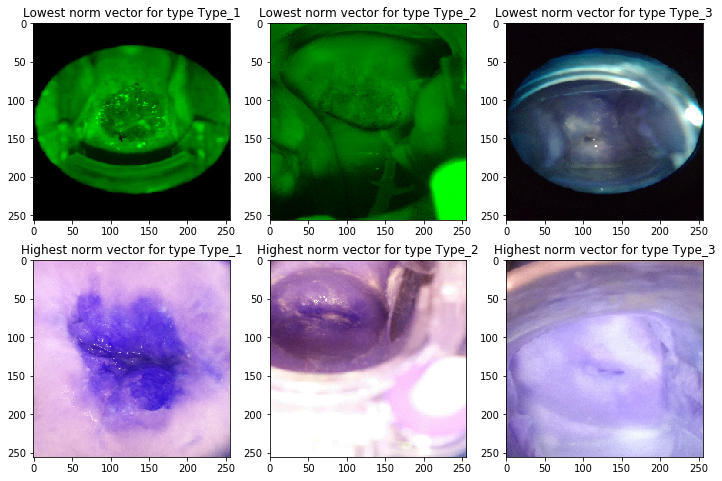

In [85]:
fig = plt.figure(figsize=(12,8))
for i, t in enumerate(training_df.type.unique()):
    ax1 = fig.add_subplot(2,3,i+1)
    ax2 = fig.add_subplot(2,3,i+4)
    norms = [[], [], []]
    for value in training_df[training_df.type == t].img_array.values:
        norm = np.linalg.norm(value)
        norms[i].append(norm)
    ax1.imshow(training_df[training_df.type==t].img_array.values[norms[i].index(min(norms[i]))])
    ax1.set_title('Lowest norm vector for type {}'.format(t))
    ax2.imshow(training_df[training_df.type==t].img_array.values[norms[i].index(max(norms[i]))])
    ax2.set_title('Highest norm vector for type {}'.format(t))


#### Overlay Images

In [ ]:
import Image
overlayed = Image.blend()